In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt', download_dir='/Users/data/VsCodeProjects/DataScience/.venv/nltk_data')
nltk.download('stopwords', download_dir='/Users/data/VsCodeProjects/DataScience/.venv/nltk_data')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score, precision_recall_curve, precision_score
from matplotlib import pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import GridSearchCV


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/data/VsCodeProjects/DataScience/.venv/nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/data/VsCodeProjects/DataScience/.venv/nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/Users/data/VsCodeProjects/DataScience/data/raw/labeled.csv', sep=',')
df.head()


,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [4]:
df.toxic = df.toxic.apply(int)
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [5]:
df.toxic.value_counts()

toxic
0    9586
1    4826
Name: count, dtype: int64

In [6]:
for c in df[df.toxic == 0]['comment'].head(5):
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [7]:
train_df, test_df = train_test_split(df, test_size=500)

In [24]:
test_df.shape

(500, 2)

In [ ]:
x, y = test_df.toxic.value_counts()
x / y



2.2679738562091503

In [8]:
sentence_example = df.iloc[1]['comment']
tokenizer = WordPunctTokenizer()
tokens = tokenizer.tokenize(sentence_example)
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words('russian')
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snwowball = SnowballStemmer(language='russian')
stemmed_tokens = [snwowball.stem(i) for i in tokens_without_stop_words_and_punctuation  ]

In [9]:
snowball = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')
tokenizer = WordPunctTokenizer()

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = tokenizer.tokenize(sentence)
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [58]:
tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [10]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [11]:
features = vectorizer.fit_transform(train_df.comment)

/Users/data/VsCodeProjects/DataScience/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df.toxic)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [13]:
model.predict(features[0])

array([1])

In [14]:
train_df['comment'].iloc[0]

'Перед кем ты распинаешься )? Разговор слышащего с глухими.\n'

In [15]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0))
])

In [16]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

/Users/data/VsCodeProjects/DataScience/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,steps,"[('vectorizer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function <la...t 0x1351ad120>


In [102]:
model_pipeline.predict(['ты молодец'])


array([0])

In [25]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.8880597014925373

In [26]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.695906432748538

In [ ]:
y_true = test_df['toxic']
y_score = model_pipeline.predict_proba(test_df['comment'])[:, 1]

prec, rec, tresholds = precision_recall_curve(y_true, y_score)

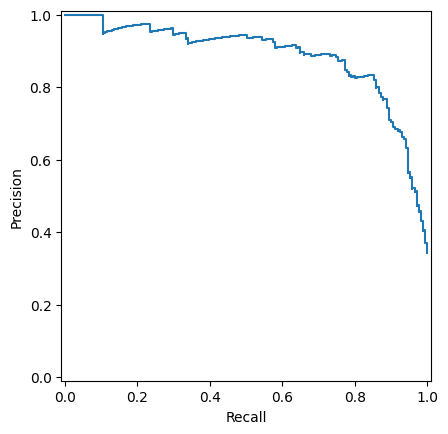

In [36]:
disp = PrecisionRecallDisplay(precision=prec, recall=rec)
disp.plot()
plt.show()


In [37]:
np.where(prec > 0.95)

(array([445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
        458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
        471, 472, 473, 474, 475, 476, 477, 480, 481, 482, 483, 484, 485,
        486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498]),)

In [39]:
tresholds[445]

np.float64(0.8013008870559046)

In [48]:
grid_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x:tokenize_sentence(x, remove_stop_words=True))),
    ('model',
     GridSearchCV(
         LogisticRegression(random_state=0),
         param_grid={F'C': [0.1, 1, 10]},
         cv=3,
         verbose=4
     )
     )
])

In [49]:
grid_pipeline.fit(train_df['comment'], train_df['toxic'])

/Users/data/VsCodeProjects/DataScience/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.691 total time=   0.0s
[CV 2/3] END .............................C=0.1;, score=0.687 total time=   0.0s
[CV 3/3] END .............................C=0.1;, score=0.689 total time=   0.0s
[CV 1/3] END ...............................C=1;, score=0.835 total time=   0.0s
[CV 2/3] END ...............................C=1;, score=0.844 total time=   0.1s
[CV 3/3] END ...............................C=1;, score=0.842 total time=   0.1s
[CV 1/3] END ..............................C=10;, score=0.860 total time=   0.1s
[CV 2/3] END ..............................C=10;, score=0.870 total time=   0.1s
[CV 3/3] END ..............................C=10;, score=0.873 total time=   0.1s


,steps,"[('vectorizer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function <la...t 0x1370680e0>


In [76]:
grid_pipeline.predict(['погода чудесная'])

array([0])